# Task 1: The Cheater
## "All models are wrong, some are useful." — George Box

In this notebook, we intentionally train a simple CNN on a **biased** dataset where the digit label is spuriously correlated with color (e.g., 0 is usually Red). We then expose the model's laziness by testing it on a dataset where this correlation is broken.

### Goals:
1.  **Train**: Achieve >95% accuracy on the biased training set.
2.  **Verify Bias**: Show the model fails (<20% accuracy) on the unbiased/conflicting test set.
3.  **Diagnose**: Use Confusion Matrices and specific "Trap" examples to prove the model is looking at color, not shape.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath('..'))

from sklearn.metrics import confusion_matrix
from src.data.biased_mnist import BiasedMNIST
from src.models.simple_cnn import SimpleCNN
import torch.nn.functional as F
import torchvision.transforms as transforms

# Check Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## 1. Data Loading
We load the `BiasedMNIST` dataset.
- **Train**: `bias_ratio=0.95`. (0 is Red 95% of the time).
- **Test**: `bias_ratio=0.0`. (Colors are randomized, specifically avoiding the 'correct' color to punish the model).


In [2]:
# Hyperparameters
BATCH_SIZE = 64

# Load Data
train_dataset = BiasedMNIST(root='./data', train=True, download=True, bias_ratio=0.995)
test_dataset = BiasedMNIST(root='./data', train=False, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train Size: {len(train_dataset)}")
print(f"Test Size: {len(test_dataset)}")


Train Size: 60000
Test Size: 10000


## 2. Model Training
We use a simple 3-layer CNN. It has enough capacity to learn MNIST, but is also lazy enough to grab the easiest feature (color).


Training on Biased Dataset...


Epoch 1/5, Loss: 0.1584, Accuracy: 96.45%


Epoch 2/5, Loss: 0.0376, Accuracy: 99.31%


Epoch 3/5, Loss: 0.0286, Accuracy: 99.48%


Epoch 4/5, Loss: 0.0213, Accuracy: 99.58%


Epoch 5/5, Loss: 0.0183, Accuracy: 99.59%


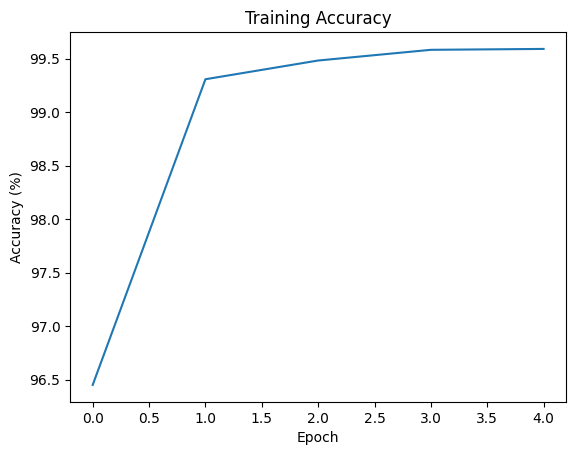

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # Input: 3 x 28 x 28
        # Drastically reduced capacity to force color reliance
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # After pool 1: 8 x 14 x 14
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        # After pool 2: 16 x 7 x 7
        self.fc = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 7 * 7)
        x = self.fc(x)
        return x

model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


def train(model, loader, epochs=5):
    model.train()
    train_accs = []
    
    for epoch in range(epochs):
        correct = 0
        total = 0
        running_loss = 0.0
        
        for images, labels, colors in loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
        acc = 100 * correct / total
        train_accs.append(acc)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(loader):.4f}, Accuracy: {acc:.2f}%")
    
    return train_accs

# Train the model
print("Training on Biased Dataset...")
history = train(model, train_loader, epochs=5)

plt.plot(history)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()


## 3. The Trap: Evaluation on Unbiased Data
Now we test the model on the "Hard" set. If the model learned to recognize **shapes** (digits), it should perform reasonably well (>90%). If it learned **colors**, it will fail catastrophically because the color correlation is broken.


In [4]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, colors in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    acc = 100 * correct / total
    print(f"Test Set Accuracy: {acc:.2f}%")
    return all_labels, all_preds

print("Evaluating on Bias-Conflicting Test Set...")
labels, preds = evaluate(model, test_loader)


Evaluating on Bias-Conflicting Test Set...


Test Set Accuracy: 57.34%


## 4. Analysis
### Confusion Matrix
Let's see what the model is actually predicting.


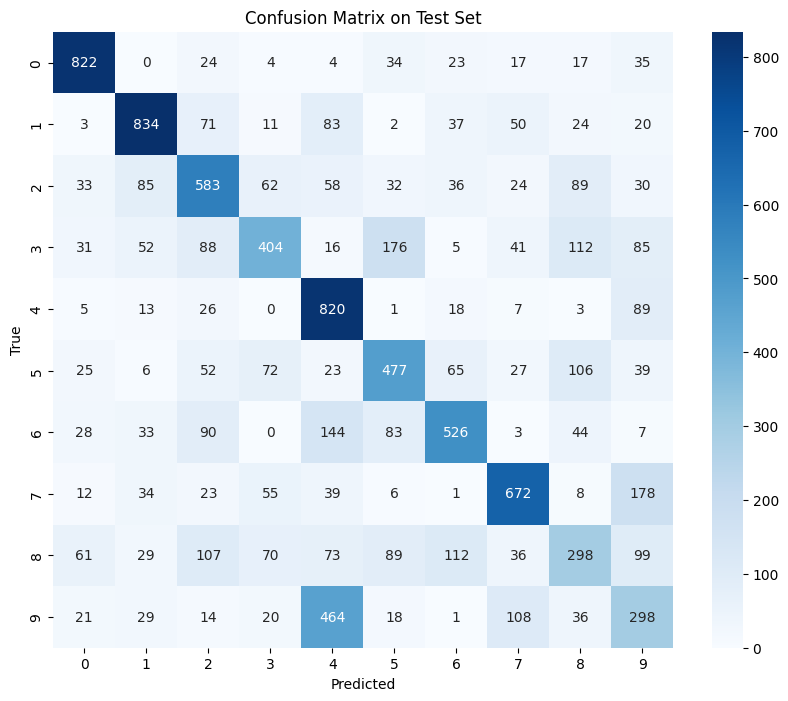

In [5]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()


### The "Red 1" Trap
Let's specifically construct a "Red 1". 
- **Truth**: Digit 1.
- **Visual**: Red Color (which implies 0 in the training set).
- **Hypothesis**: Model will predict 0.


Training Color Map (Digit -> Color):
0 -> Red
1 -> Green
Ground Truth: 1
Injected Color: Red (Correlated with 0)
Model Prediction: 1
Prediction Confidence: 0.8774


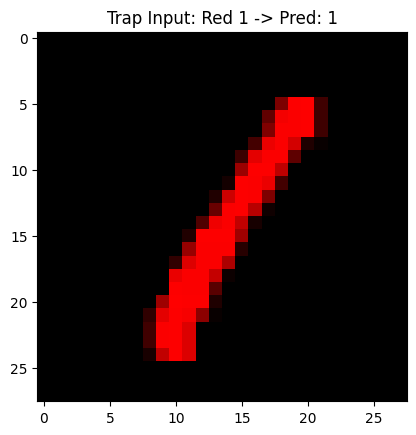

In [6]:
# Get a 1 from the dataset
# We can search the test set for a 1 that happens to be Red (unlikely in randomized test set?) or just construct it.
# Let's manually construct it for clarity using the class logic or just finding one.

# Let's verify the color map first
print("Training Color Map (Digit -> Color):")
print("0 -> Red")
print("1 -> Green")

# Find a '1' in the test set
target_digit = 1
for imgs, lbls, clrs in test_loader:
    mask = (lbls == target_digit)
    if mask.any():
        sample_img = imgs[mask][0] # Get first '1'
        break

# Now force it to be RED
# Red is color index 0: [1.0, 0, 0]
red_color = torch.tensor([1.0, 0.0, 0.0]).view(3, 1, 1).to(device)

# We need the original grayscale stroke.
# Since sample_img is already colored (randomly), we can't easily extract it without the original mask.
# Let's just create a new dummy dataset instance to grab a raw image or use the BiasedMNIST logic.
# Easier way: Just grab a 1 from a standard MNIST download or just look at the BiasedMNIST code.
# The BiasedMNIST class applies color on the fly. Let's make a manual call.

# Create a temporary 'Red 1'
# We access the internal raw data of the dataset
raw_train = BiasedMNIST(root='./data', train=True, download=True)
idx = (raw_train.targets == 1).nonzero(as_tuple=True)[0][0]
img_raw, _ = raw_train.data[idx], int(raw_train.targets[idx])
img_pil = transforms.ToPILImage()(img_raw)
img_tensor = transforms.ToTensor()(img_pil).to(device)

# Color it RED
red_1 = img_tensor * red_color
# Add batch dimension
red_1_batch = red_1.unsqueeze(0)

# Predict
model.eval()
with torch.no_grad():
    output = model(red_1_batch)
    prob_softmax = torch.softmax(output, dim=1)
    _, pred_class = torch.max(output, 1)

print(f"Ground Truth: 1")
print(f"Injected Color: Red (Correlated with 0)")
print(f"Model Prediction: {pred_class.item()}")
print(f"Prediction Confidence: {prob_softmax[0][pred_class].item():.4f}")

plt.imshow(red_1.cpu().permute(1, 2, 0))
plt.title(f"Trap Input: Red 1 -> Pred: {pred_class.item()}")
plt.show()
